In [ ]:
# MIT License
#
# Copyright (c) 2021 Fagner Cunha
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Embarcando modelos com TensorFlow Lite

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/alcunha/embedding-tflite-models-on-raspberrypi/blob/master/Embedding-Models-with-TFLite.ipynb"><img src="./images/colab_logo_32px.png" />Executar no Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/alcunha/embedding-tflite-models-on-raspberrypi/blob/master/Embedding-Models-with-TFLite.ipynb"><img src="./images/GitHub-Mark-32px.png" />Ver código no GitHub</a>
  </td>
</table>

In [ ]:
! pip install tensorflow matplotlib scikit-learn numpy pillow

In [1]:
import os, logging

import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Disable warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

AUTOTUNE = tf.data.experimental.AUTOTUNE

## TensorFlow Lite

O TensorFlow Lite é um framework multiplataforma para realizar inferência de maneira eficiente em dispositivos com recursos computacionais limitados como smartphones e dispositivos embarcados.

Para isso, os modelos pré-treinados precisam ser convertidos num formato especial compactado utilizando-se o TensorFlow Lite Converter e executar a inferência do modelo no dispotivo utilizando o Interpretador do TensorFlow Lite. Durante o processo de conversão também podem ser realizadas otimizações para reduzir tanto o tamanho quanto a latência do modelo.

## Exemplo Prático: Conversão de um modelo de visão computacional para inferência em uma Raspberry Pi

1. Carregamento do modelo
2. Conversão para o formato do TFLite
3. Instalação dos pacotes na Raspberry Pi
4. Implementação do código para inferência na Raspberry Pi
5. Benchmarking dos modelos
6. Otimização dos modelos durante a conversão

#### Carregamento do dataset

Será utilizado um subconjunto de 2 mil imagens do dataset Cats vs Dogs [1]

In [2]:
CATS_DOGS_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_path = keras.utils.get_file('cats_and_dogs.zip', origin=CATS_DOGS_URL, extract=True)
dataset_path = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')
train_path = os.path.join(dataset_path, 'train')
validation_path = os.path.join(dataset_path, 'validation')

In [3]:
INPUT_SIZE = 224
BATCH_SIZE = 1
classes = ['cats', 'dogs']

#### Preparação do pipeline de dados

In [4]:
def string_to_one_hot(label):
    one_hot = tf.stack([tf.equal(label, s) for s in classes], axis=-1)
    one_hot = tf.cast(one_hot, tf.float32)
    
    return one_hot

In [5]:
def get_label_from_filename(filename):
    label = tf.strings.split(filename, os.path.sep)[-2]
    label = string_to_one_hot(label)
    
    return filename, label

In [6]:
def load_and_preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, size=(INPUT_SIZE, INPUT_SIZE))
    
    return image, label

In [7]:
dataset = tf.data.Dataset.list_files(str(validation_path+'/*/*'), shuffle=True)
dataset = dataset.map(get_label_from_filename, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

Classe: cats


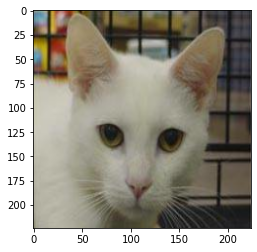

In [8]:
image, label = next(iter(dataset))
print("Classe: %s" % classes[tf.argmax(label[0])])
plt.imshow(image[0])

#### Carregamento do modelo treinado

A acurácia do modelo na base de validação é de 98.60%.

In [9]:
base_model = MobileNetV2(input_shape=(INPUT_SIZE,INPUT_SIZE,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

Os pesos do modelo pré-treinados podem ser baixados pelo [link](https://drive.google.com/file/d/1zNcy41ZVe4VgDTGYeOw0iGVqYAofhBK7/view?usp=sharing).

In [10]:
model.load_weights('mobilenetv2_cats_and_dogs_08jan.h5')

A compilação do modelo é necessária para utilizar a função evaluate para avaliar o modelo:

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.evaluate(dataset, batch_size=BATCH_SIZE)

1000/1000 [==============================] - 5s 5ms/step - loss: 0.0413 - accuracy: 0.9860


[0.04133117198944092, 0.9860000014305115]

In [13]:
model.metrics_names

['loss', 'accuracy']

### Conversão do modelo para TFLite

Para converter modelos para o TF Lite utiliza-se o `tf.lite.TFLiteConverter`, podendo fazer a conversão de modelos do Keras, modelos no formato SavedModel e funções concretas. Há também uma [api por linha de comando](https://www.tensorflow.org/lite/convert?hl=pt-br#command_line_tool_) onde é possível converter modelos salvos no formato SavedModel ou H5.

#### Convertendo modelo do keras:

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('mobilenetv2_cats_and_dogs_keras.tflite', 'wb') as f:
    f.write(tflite_model)

#### Convertendo modelo no formato SavedModel:

In [15]:
model.save('saved_model/mobilenetv2')

In [16]:
!ls saved_model/mobilenetv2

assets	saved_model.pb	variables


In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/mobilenetv2')
tflite_savedmodel = converter.convert()
with open('mobilenetv2_cats_and_dogs_savedmodel.tflite', 'wb') as f:
    f.write(tflite_savedmodel)

### Inferência com o modelo TFLite

Para fazer inferência é necessário utilizar o Interpretador do TFLite utilizando o `tf.lite.Interpreter` do TensorFlow ou o `tflite_runtime.interpreter.Interpreter` para o pacote do TFLite na Raspberry Pi.

In [18]:
interpreter = tf.lite.Interpreter('mobilenetv2_cats_and_dogs_keras.tflite')
interpreter.allocate_tensors()

#### Inspecionando entradas e saídas

In [19]:
interpreter.get_input_details()

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [20]:
interpreter.get_output_details()

[{'name': 'Identity',
  'index': 178,
  'shape': array([1, 2], dtype=int32),
  'shape_signature': array([-1,  2], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

#### Realizando a inferência

In [21]:
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()

In [22]:
output_details = interpreter.get_output_details()
interpreter.get_tensor(output_details[0]['index'])

array([[9.9988973e-01, 1.1022780e-04]], dtype=float32)

In [23]:
model.predict(image)

array([[9.9988973e-01, 1.1022706e-04]], dtype=float32)

In [24]:
def load_model(model_path):
    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()
    
    return interpreter

In [25]:
def classify_image(interpreter, image):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    
    return predictions[0]

In [26]:
tflite_savedModel = load_model('mobilenetv2_cats_and_dogs_savedmodel.tflite')
classify_image(tflite_savedModel, image)

array([9.9988973e-01, 1.1022780e-04], dtype=float32)

#### Verificando a acurácia

In [27]:
def evaluate_tflite_model(interpreter, dataset):
    labels = []
    predictions = []
    for image, label in dataset:
        labels.append(np.argmax(label[0]))
        pred = classify_image(interpreter, image)
        predictions.append(np.argmax(pred))
        
        if len(labels) % 50 == 0:
            print('.', end='')
    
    print('\nAccuracy: %.2f%%' % (100*accuracy_score(labels, predictions)))

In [28]:
evaluate_tflite_model(tflite_savedModel, dataset)

....................
Accuracy: 98.60%


### Instalação do interpretador do TFLite na Raspberry Pi

Para fazer inferência na Raspberry Pi não é necessário instalar o Tensorflow (apesar de ser possível), basta instalar o interpretador do TF Lite (<2MB). O TensorFlow disponibiliza vários [pacotes pré-compilados](https://www.tensorflow.org/lite/guide/python) que podem ser instalados utilizando o `pip`. É necessário escolher corretamente a arquitetura, o SO e a versão do Python, por exemplo, para a Raspberry Pi deste tutorial:

<code>$ pip3 install https://github.com/google-coral/pycoral/releases/download/release-frogfish/tflite_runtime-2.5.0-cp37-cp37m-linux_armv7l.whl</code>

Há também a possibilidade de compilar o interpretador, veja o [link](https://www.tensorflow.org/lite/guide/build_rpi).

### Pré-processamento para Raspberry Pi

Ao instalar apenas o interpretador do TF Lite, nenhuma das demais funções do TensorFlow estarão disponíveis na Raspberry Pi. Assim, o pré-processamento que estava sendo feito utilizando as funções nativas do TF precisarão ser migradas. Isso pode ser feito tanto adicionando as etapas de pré-processamento ao modelo antes da conversão ou utilizando outras bibliotecas disponíveis no Python como NumPy, PIL e OpenCV.

As versões mais recentes do Keras possuem camadas de pré-processamento prontas para serem acopladas aos modelos, tornando mais prático o deployment, sem a necessidade de utilizar outros pacotes para pré-processar a entrada. No entanto, pré-processamento mais espécificos necessitam ser implementados manualmente e muitas vezes é necessário fazer a conversão do modelo com [funções concretas](https://www.tensorflow.org/lite/convert?hl=pt-br#convert_concrete_functions_). Ainda assim, existem funções do TF que ainda não podem ser convertidas para o TFLite como a função de decodificação de arquivo jpeg. Por iss, para esse tutorial serão utilizadas as bibliotecas PIL e NumPy para fazer o pré-processamento da image.

Vale ressaltar que as funções de bibliotecas diferentes podem conter implementações diferentes e, portanto, podem haver pequenas variações no resultado do modelo devido o pré-processamento.

In [29]:
from PIL import Image

In [30]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((INPUT_SIZE, INPUT_SIZE), Image.ANTIALIAS)
    image = np.asarray(image, dtype=np.float32)
    image = image/255
    image = np.expand_dims(image, axis=0)
    
    return image

In [ ]:
train_path

In [31]:
image_path = "{}/cats/cat.403.jpg".format(train_path)

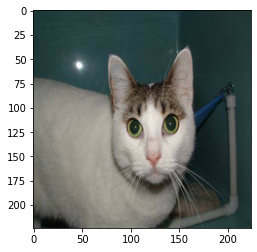

In [32]:
pil_image = load_and_preprocess_image(image_path)
plt.imshow(pil_image[0])

In [33]:
classify_image(tflite_savedModel, pil_image)

array([9.9993336e-01, 6.6612585e-05], dtype=float32)

In [34]:
def evaluate_tflite_model_with_pil(interpreter, image_list, classes):
    labels = []
    predictions = []
    for image_path in image_list:
        label = classes.index(image_path.split('/')[-2])
        image = load_and_preprocess_image(image_path)
        
        labels.append(label)
        pred = classify_image(interpreter, image)
        predictions.append(np.argmax(pred))
        
        if len(labels) % 50 == 0:
            print('.', end='')
    
    print('\nAccuracy: %.2f%%' % (100*accuracy_score(labels, predictions)))

In [35]:
image_list = glob.glob('{}/*/*'.format(validation_path))

In [36]:
evaluate_tflite_model_with_pil(tflite_savedModel, image_list, classes)

....................
Accuracy: 98.90%


#### Código para inferência na Raspberry Pi

O código completo para inferência na Raspberry Pi está disponível no [respositório](https://github.com/alcunha/embedding-tflite-models-on-raspberrypi/blob/master/mobilenet_predict.py). Foram feitas pequenas modificações no código para leitura dos argumentos, apresentação dos resultados e estimativa de tempo de inferência.

#### Ferramenta para benchmarking do TensorFlow Lite

O TensorFlow Lite possui algumas ferramentas para medição de desempenho. Para mais informações e download dos binários pa pode ser feito no [link](https://www.tensorflow.org/lite/performance/measurement).

### Quantização pós-treinamento

Existem diversas técnicas para otimizar modelos como quantização, destilação e poda. A quantização funciona reduzindo a precisão dos números para reduzir tamanho do modelo e a latência da predição, podendo ser aplicada tanto no modelo já treinado quanto durante o treinamento, o que geralmente traz melhores resultados.

O TensorFlow Lite oferece uma série de [opções de otimização](https://www.tensorflow.org/lite/performance/model_optimization), sendo a quantização pós-treinamento uma das mais simples de ser aplicada, otimizando um modelo ao custo de alguma acurácia. Além disso, dependendo do tipo de hardware a ser utilizado, é necessário fazer a quantização de maneiras específicas (somente INT8, FLOAT16, etc.), para isso é importante consultar o manual do fabricante e o material disponível na documentação do Tensorflow Lite.

#### Quantização de faixa dinâmica

Para esse tipo de quantização habilita-se a opção `optimizations` do conversor no modo padrão com `tf.lite.Optimize.DEFAULT`. Nessa opção os parâmetros fixos do modelo como os pesos da rede, por exemplo, são quantizados.

Nessa operação, entradas e saídas da rede continuam sendo do tipo float32 para manter compatibilidade com o modelo original.

In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('mobilenetv2_cats_and_dogs_quant.tflite', 'wb') as f:
    f.write(tflite_model)

In [38]:
model_quant = load_model('mobilenetv2_cats_and_dogs_quant.tflite')
image_list = glob.glob('{}/*/*'.format(validation_path))
evaluate_tflite_model_with_pil(model_quant, image_list, classes)

....................
Accuracy: 76.80%


#### Quantização de fallback fluante

Com essa opção as variáveis intermediárias também são quantizadas, mas é necessário fornecer um conjunto de amostras representativa para que o otimizador estime a faixa de operação típica dessas variáveis. O recomendado é que esse conjunto tenha entre 100 e 500 amostras que podem ser do treino ou da validação e não precisam ser rotuladas. Além de ativar a otimização no modo padrão, o dataset representative é configurado utilizando a opção `representative_dataset` do conversor.

In [39]:
def representative_dataset():
    for image, label in dataset.take(100):
        yield [image]

In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()
with open('mobilenetv2_cats_and_dogs_quant_fallback.tflite', 'wb') as f:
    f.write(tflite_model)

In [41]:
model_quant_fallback = load_model('mobilenetv2_cats_and_dogs_quant_fallback.tflite')
image_list = glob.glob('{}/*/*'.format(validation_path))
evaluate_tflite_model_with_pil(model_quant_fallback, image_list, classes)

....................
Accuracy: 98.50%


### Referências

[1] Elson, Jeremy, et al. "Asirra: a CAPTCHA that exploits interest-aligned manual image categorization." ACM Conference on Computer and Communications Security. Vol. 7. 2007.